<div style="text-align: center;">
  <h1>Dividend Taxation and Top-Income Inequality</h1>
  <h3>HEC Liege</h3>
  <h4><em>Lucas Dubois</em></h4>
</div>

Firstly, let us create our database by adding the WID's data for top income inequality. The WID provides data for both the 1st and the 10th percintele, and will have both.

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats import diagnostic
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.sandwich_covariance import se_cov
from stargazer.stargazer import Stargazer
import warnings
import re

path = '/Users/lucasdubois/Desktop/MASTERDATA/' 

Since the data is registred under strange ids and needs restructuring, we proceed creating a contry map and change the dataframe:

In [284]:
df1 = pd.read_csv(path + 'WID_income_inequality4.csv', sep=';', skiprows=1, engine='python')

df1.columns = df1.columns.str.strip()

prefixes = ("sptinc_z_", "shweal_z_")

code_country_map = {}
for col in df1.columns:
    if isinstance(col, str) and col.startswith(prefixes):
        parts = col.split("\n")
        country = parts[-1].strip()
        code_country_map[col] = country

df1 = df1.rename(columns=code_country_map)

df1 = df1[df1['Percentile'] == 'p99p100']

df.head()

,Percentile,Year,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United Kingdom,Uruguay,USA,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe
0,p99p100,1807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p99p100,1808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p99p100,1809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p99p100,1810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p99p100,1811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [286]:
df1.columns = df1.columns.str.strip()

df1_l = df1.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name='Value')

df1_l['Country_Percentile'] = df1_l['Country'] + '_' + df1_l['Percentile'].str.replace('p', '')

df1_l = df1_l.pivot_table(index='Year', columns='Country_Percentile', values='Value', aggfunc='mean').reset_index()

df1 = df1_l.sort_index(axis=1)

df1.head()

Country_Percentile,Afghanistan_99100,Albania_99100,Algeria_99100,Andorra_99100,Angola_99100,Anguilla_99100,Antigua and Barbuda_99100,Argentina_99100,Armenia_99100,Aruba_99100,...,United Kingdom_99100,Uruguay_99100,Uzbekistan_99100,Vanuatu_99100,Venezuela_99100,Viet Nam_99100,Year,Yemen_99100,Zambia_99100,Zimbabwe_99100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1807,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1817,NaN,NaN,NaN
2,NaN,NaN,0.18,NaN,NaN,NaN,NaN,0.1975,NaN,NaN,...,0.248,NaN,NaN,NaN,NaN,NaN,1820,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1827,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1837,NaN,NaN,NaN


In [298]:
cols = df1.columns.tolist()

cols = ['Year'] + [col for col in cols if col != 'Year']

df1 = df1[cols]

df1= df1.round(4)

This yields an organized dataframe that we'll then merge to construct a final version after.

In [290]:
df1.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WID.csv", index=False)

<p>
The paper by Roine et al., 2009 provides several empirical insights regarding the long-run determinants of top-income inequality. Their approach (FDGLS and DFD) is nothing short of similar to mine, thus making their contribuition particularly interesting. I intend to add their results as controls in my endeavor, in order to add more information to the models and hopefuly improve it. Note nonetheless that the long-run nature of this project and the sample (mostly developed countries) might render some controls not significant or of magnitude in the model, but that we can only know when trying.
From their results, the authors find the following determinants to be statistically significant:
</p>

- Financial Development (total capitalization as a sum of bank deposits and market cap.)  (+)
- Income per capita (GDP per capita) (+)
- Marginal taxes (-)

The gdp is in Euro and constant for 2023 (ppp)

In [318]:
years = list(range(1995, 2024))

columns = ["Country Name", "Country Code", "Series Name", "Series Code"] + years

df_raw = pd.read_csv(
    path + 'World_Bank1.csv',
    sep=',',
    names=columns,
    engine='python',
    encoding='utf-8',
    skiprows=0,
    on_bad_lines='skip'
)

df_long = df_raw.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year",
    value_name="Value"
)

df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")  # ✅ important fix

df_pivot = df_long.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Code",
    values="Value"
).reset_index()

df_pivot = df_pivot.rename(columns={
    "NW.DOW.PC.CD": "domestic_wealth_pc",
    "NW.NFA.PC.CD": "foreign_assets_pc",
    "NW.NFL.PC.CD": "foreign_liabilities_pc",
    "NW.HCA.PC.CD": "human_capital_pc",
    "NW.TOW.TO.CD": "national_wealth_total",
    "NW.DOW.TO.CD": "domestic_wealth_total"
})

df_pivot = df_pivot.sort_values(["Country Name", "Year"]).reset_index(drop=True)

df2 = df_pivot.round(2)

df2.head()


Series Code,Country Name,Year,domestic_wealth_pc,domestic_wealth_total,human_capital_pc,foreign_assets_pc,foreign_liabilities_pc,national_wealth_total
0,Albania,1995,10150.35,3.235712e+10,4257.13,163.44,194.81,3.225712e+10
1,Albania,1996,12135.21,3.844475e+10,4950.64,208.96,231.69,3.837275e+10
2,Albania,1997,10135.05,3.190797e+10,3446.47,195.34,250.30,3.173497e+10
3,Albania,1998,11211.24,3.507471e+10,3739.96,249.00,310.69,3.488171e+10
4,Albania,1999,12807.14,3.981456e+10,4502.05,315.56,372.82,3.963656e+10


In [320]:
df2.to_csv("/Users/lucasdubois/Desktop/MASTERDATA/Final_WB1.csv", index=False)

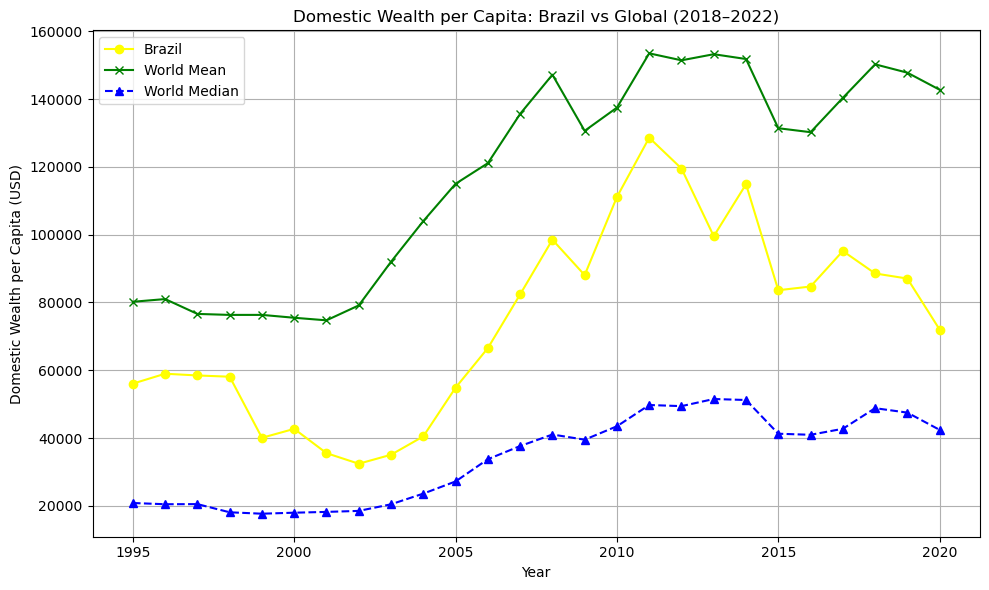

In [322]:
years = list(range(1995, 2023))

df_filtered = df_pivot[df_pivot['Year'].isin(years)]

world_mean = df_filtered.groupby('Year')['domestic_wealth_pc'].mean()

world_median = df_filtered.groupby('Year')['domestic_wealth_pc'].median()

brazil_data = df_filtered[df_filtered['Country Name'] == 'Brazil'].set_index('Year')['domestic_wealth_pc']

plt.figure(figsize=(10, 6))
plt.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="yellow")
plt.plot(world_mean.index, world_mean.values, marker='x', label='World Mean',color="green")
plt.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--',color="blue")

plt.title('Domestic Wealth per Capita: Brazil vs Global (2018–2022)')
plt.xlabel('Year')
plt.ylabel('Domestic Wealth per Capita (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


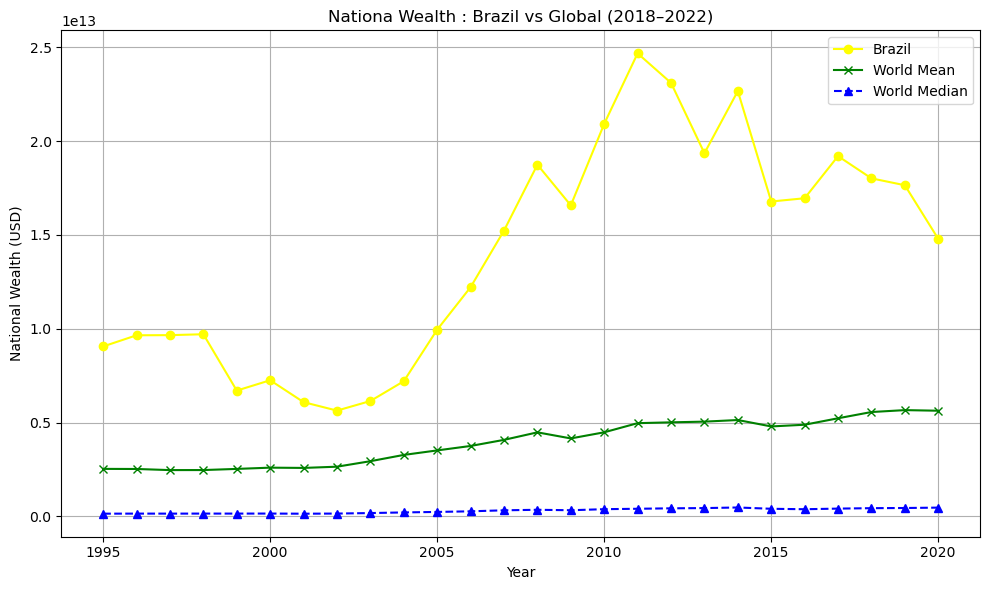

In [314]:
years = list(range(1995, 2023))

df_filtered = df_pivot[df_pivot['Year'].isin(years)]

world_mean = df_filtered.groupby('Year')['national_wealth_total'].mean()

world_median = df_filtered.groupby('Year')['national_wealth_total'].median()

brazil_data = df_filtered[df_filtered['Country Name'] == 'Brazil'].set_index('Year')['national_wealth_total']

plt.figure(figsize=(10, 6))
plt.plot(brazil_data.index, brazil_data.values, marker='o', label='Brazil', color="yellow")
plt.plot(world_mean.index, world_mean.values, marker='x', label='World Mean',color="green")
plt.plot(world_median.index, world_median.values, marker='^', label='World Median', linestyle='--', color="blue")

plt.title('Nationa Wealth : Brazil vs Global (2018–2022)')
plt.xlabel('Year')
plt.ylabel('National Wealth (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
